First implementation of a trajectory transformer, where each observation is a vector of [lat lon, sog, cog]

In [31]:
import numpy as np 
import torch
import torch.nn as nn
import torch.functional as f
import torch.nn.functional as F
import pickle 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm as tnb
from tqdm import tqdm

torch.set_default_dtype(torch.float64)

In [42]:
class MarineDataset(Dataset):
    def __init__(self, data_dictionary, min_seq_len, max_seq_len, n_features):

        self.min_seq_len = min_seq_len
        self.max_seq_len = max_seq_len
        self.n_features = n_features

        self.dict = data_dictionary
        self.keys = list(data_dictionary.keys())

        for key in self.keys:
            if len(self.dict[key]['traj']) < min_seq_len:
                del self.dict[key]
                self.keys.remove(key)


    def __len__(self):
        return len(self.dict)
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        traj_data = self.dict[key]['traj']
        
        # Cut off the mmsi and timestamp and return trajectory
        if len(traj_data) >= self.max_seq_len:
            return torch.tensor(traj_data[:self.max_seq_len,:self.n_features])
        else: 
            needed_padding = self.max_seq_len - len(traj_data)
            res = F.pad(torch.tensor(traj_data[:,:self.n_features]), (0,0, 0, needed_padding), "constant", 0.0)
        
            return res    


In [33]:
# Parameters (could move to config file if wanna be fancy)

d_model = 128 # Size of the embedding space
max_seq_time = 64 # Maximum number of observations per trajectory
min_seq_time = 30
input_dim = 4 # [lat, lon, sog, cog]
output_dim = input_dim # [lat, lon, sog, cog]
n_enc_layers = 6 
n_dec_layers = n_enc_layers
n_heads = 4 # number of attentionheads in the encoder and decoder
d_ff = 512 # Dimension of the ff nn at the end of a block
d_latent = 32 # Dimension of the latent space (Perhaps uneccesary)
segment_length = 10 # Sliding window length if we want to use this over the avg across all time

params = [input_dim, d_model, n_heads, n_enc_layers, n_dec_layers, d_ff, max_seq_time, d_latent, segment_length, output_dim]

torch.pi = torch.acos(torch.zeros(1)).item() *2 # Define pi (not sure why tho)

In [43]:
class PositionalEncoding(nn.Module):
    """
    Postional encoder using the sinusiodals from the original paper
    """
    
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype = torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()*(-torch.log(torch.tensor(10000.0))/d_model))
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0).transpose(0,1)
        self.pe =  pe # self.pe is a matrix where the first dim is T, second is batch, and third is model/embdedding dim

    def forward(self, x):
        # We will overlay the positional encoding on the input. Take only x.size(0) in case we have shorter seqs.
        x = x + self.pe[:x.size(0), :]
        return x
    

class TrajectoryEncoder(nn.Module):
    """
    Basic Encoder relying mainly on pytorchs modules 
    """
    def __init__(self, input_dim, d_model, n_heads, n_enc_layers, d_ff, max_len, 
                 d_latent, segment_length):
        super(TrajectoryEncoder, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model) # Project from input dim to embedding dim
        self.pos_enc = PositionalEncoding(d_model, max_len) # Apply the positional encoding to the embedded features
        enc_layers = nn.TransformerEncoderLayer(d_model, n_heads, d_ff) # Create the encoder layers and the encoder stack from torchs own modules
        self.transformer_encoder = nn.TransformerEncoder(enc_layers, n_enc_layers)
        self.segment_length = segment_length
        self.latent_proj = nn.Linear(d_model, d_latent)

    def forward(self, src):

        ## Pre process and add positional encoding
        
        # Take our input from 5-d to embedding-d
        x = self.input_proj(src )

        # Positionally encode the emdedded vectors 
        x = self.pos_enc(x)

        # Step through encoder stack
        x = self.transformer_encoder(x)
        
        ## Make a latent transformation by first taking the mean across the model dimensions and then passing through
        ## a linear layer (might be unneccesary though, maybe could only use the model space instead(?))

        #encoded = torch.mean(x, dim = 0)
        encoded = x
        latent = self.latent_proj(encoded)
        

        # Try returning what is encoded. Then the dimension will be T, bs, n_emb
        return encoded




In [44]:
class TrajectoryDecoder(nn.Module):

    def __init__(self, d_latent, d_model, n_heads, n_dec_layers, d_ff, max_len, 
                 output_dim, segment_length ):
        super(TrajectoryDecoder, self).__init__()
        self.latent_proj = nn.Linear(d_latent, d_model)
        self.emb_proj = nn.Linear(output_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        dec_layers = nn.TransformerDecoderLayer(d_model, n_heads, d_ff)
        self.transformer_decoder = nn.TransformerDecoder(dec_layers, n_dec_layers)
        self.output_proj = nn.Linear(d_model, output_dim)
        self.segment_length = segment_length

    def forward(self, tgt, memory, tgt_mask = None, memory_mask = None):


        """
        tgt (Tensor) = the sequence to the decoder (required).

        memory (Tensor) = the sequence from the last layer of the encoder. Size T, bs, n_emb
        """
        # Get dimensions of memory tensor
        T, batch_size, n_emb = memory.size()
        
        # Upscale from d_latent to d_model
        #memory_dm = self.latent_proj(memory)
        
        # Positionally encode the targets (maybe shift this shizzle)
        tgt = self.emb_proj(tgt)
        target = self.pos_enc(tgt)
        # Pass through decoder layer
        decoded = self.transformer_decoder(target, memory, tgt_mask = tgt_mask, memory_mask = memory_mask)

        # Scale from d_model to d_output (5)
        output = self.output_proj(decoded)
        
        return output

In [45]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [46]:
class TrajectoryAutoencoder(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, n_enc_layers, n_dec_layers, d_ff, max_len, d_latent, segment_length, output_dim):
        super(TrajectoryAutoencoder, self).__init__()
        self.encoder = TrajectoryEncoder(input_dim, d_model, n_heads, n_enc_layers, d_ff, max_len, d_latent, segment_length)
        self.decoder = TrajectoryDecoder(d_latent, d_model, n_heads, n_dec_layers, d_ff, max_len, output_dim, segment_length)

    def forward(self, tgt):
        memory = self.encoder(tgt)
        tgt_mask = generate_square_subsequent_mask(tgt.size(0))
        reconstructed = self.decoder(tgt, memory, tgt_mask = tgt_mask)
        return reconstructed


In [47]:
import pickle 
min_time = min_seq_time
if min_time>max_seq_time:
    min_time = max_seq_time
    


with open('../Data/marinedata_train.pkl', 'rb') as f:
    train_data = pickle.load(f)


train_dataloader = DataLoader(MarineDataset(train_data, min_seq_len = min_seq_time, max_seq_len = max_seq_time, n_features  =input_dim), batch_size=64, shuffle = True)


with open('../Data/marinedata_val.pkl', 'rb') as f:
    val_data = pickle.load(f)

validation_dataloader = DataLoader(MarineDataset(val_data, min_seq_len = min_seq_time, max_seq_len = max_seq_time, n_features = input_dim), batch_size=64, shuffle = True)


In [9]:
n_train_samples = 100
min_time = 40
max_time = 40

training_data = torch.zeros(size = (max_time, n_train_samples, input_dim)) 

iAddedSamples = 0
iCounter = 0

while iCounter < len(train_data.keys()):
    curr_data = train_data[iCounter]['traj']
    if len(curr_data) >= min_time:
        for j in range(min(len(curr_data), max_time)):
            training_data[j,iAddedSamples,:] = torch.tensor(curr_data[j][0:input_dim])
        iAddedSamples = iAddedSamples +1
        if iAddedSamples == n_train_samples:
            print(iAddedSamples, 'samples added to the training tensor')
            break
    iCounter += 1
if iCounter == len(train_data.keys()):    
    print('Did not find enough datapoints that were long enough.')

100 samples added to the training tensor


In [56]:
# TODO 
# Fix the model input and try to train

# Lat min 53.4 max 66.2
# lon min 9.4 max 30.5
# Max speed 50
# Max heading 360
def training_data_generator(batch_size, batch_id ):
    max_time = 40
    min_time = 40

    training_data = torch.zeros(size = (max_time, batch_size, input_dim)) 

    iAddedSamples = 0
    iCounter = batch_id*batch_size

    while iCounter < len(train_data.keys()):
        curr_data = train_data[iCounter]['traj']
        if len(curr_data) >= min_time:
            for j in range(min(len(curr_data), max_time)):
                training_data[j,iAddedSamples,:] = torch.tensor(curr_data[j][0:input_dim])
            iAddedSamples = iAddedSamples +1
            if iAddedSamples == batch_size:
                return training_data
        iCounter += 1
    return None




def train_loop(model, dataloader, criterion, optimizer):
    train_data_size = len(dataloader.dataset)
    model.train()
    batch_size = 64

    for batch, X in enumerate(dataloader):
        optimizer.zero_grad()
        #training_data = training_data_generator(batch_size, batch)
        output = model(X)
        loss = criterion(output, X)
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            print(f' loss {loss.item():>4f} [{batch*batch_size + len(X):>5d} / {train_data_size:>5d} ] ', flush = True)


def test_loop(model, dataloader, criterion):
    model.eval()
    n_batches = len(dataloader)
    cum_loss = 0
    with torch.no_grad():
        for X in dataloader:
            pred = model(X)
            cum_loss = criterion(X, pred).item()
    print(f'Test set: \nCumulative loss: {cum_loss}, Average Loss {cum_loss/n_batches:>8f}')




In [52]:
model = TrajectoryAutoencoder(*params)

criterion = nn.MSELoss()


In [57]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_epochs = 2
batch_size = 64

for epoch in range(n_epochs):
    print(f'Fuck you; It\'s epoch #{epoch + 1}')
    train_loop(model, dataloader = train_dataloader, criterion = criterion, optimizer = optimizer)
    test_loop(model, dataloader = validation_dataloader, criterion = criterion)

print('LGF!')

Fuck you; It's epoch #1
 loss 0.075776 [   64 /  9967 ] 
 loss 0.097104 [  192 /  9967 ] 
 loss 0.172749 [  320 /  9967 ] 
 loss 0.119024 [  448 /  9967 ] 
 loss 0.061731 [  576 /  9967 ] 
 loss 0.113265 [  704 /  9967 ] 
 loss 0.101101 [  832 /  9967 ] 
 loss 0.067706 [  960 /  9967 ] 
 loss 0.085841 [ 1088 /  9967 ] 
 loss 0.084809 [ 1216 /  9967 ] 
 loss 0.074285 [ 1344 /  9967 ] 
 loss 0.067883 [ 1472 /  9967 ] 
 loss 0.069195 [ 1600 /  9967 ] 
 loss 0.066242 [ 1728 /  9967 ] 
 loss 0.062814 [ 1856 /  9967 ] 
 loss 0.063469 [ 1984 /  9967 ] 
 loss 0.059162 [ 2112 /  9967 ] 
 loss 0.070894 [ 2240 /  9967 ] 
 loss 0.067730 [ 2368 /  9967 ] 
 loss 0.061347 [ 2496 /  9967 ] 
 loss 0.062764 [ 2624 /  9967 ] 
 loss 0.057976 [ 2752 /  9967 ] 
 loss 0.060769 [ 2880 /  9967 ] 
 loss 0.058953 [ 3008 /  9967 ] 
 loss 0.060750 [ 3136 /  9967 ] 
 loss 0.058673 [ 3264 /  9967 ] 
 loss 0.065247 [ 3392 /  9967 ] 
 loss 0.064950 [ 3520 /  9967 ] 
 loss 0.071311 [ 3648 /  9967 ] 
 loss 0.062956 [ 37

In [107]:
def plot_some_paths( model, val_loader, t_max, criterion ):
    
    model.eval()

    rand_sample = next(iter(val_loader))[0]
    rand_sample = rand_sample.unsqueeze(1)
    with torch.no_grad():
        recon_sample = model(rand_sample)

    recon_sample = recon_sample.squeeze()
    rand_sample = rand_sample.squeeze()
    
    meas_x, meas_y = [], []
    model_x, model_y = [], []

    for i in range(t_max):
        meas_x.append(rand_sample[i,0].item())
        meas_y.append(rand_sample[i,1].item())
        model_x.append(recon_sample[i,0].item())
        model_y.append(recon_sample[i,1].item())


    mse_error = criterion(rand_sample, recon_sample)

    plt.plot(meas_x, meas_y, 'b', label = "True traj")
    plt.plot(model_x, model_y, 'k', label = "Est path")
    plt.title(f"MSE = {mse_error:.6f}")
    plt.legend()

    plt.show()


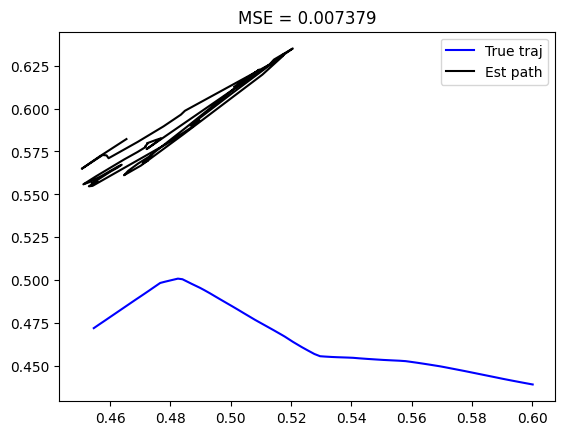

In [181]:
plot_some_paths(model, validation_dataloader, max_seq_time, criterion)

In [31]:
with open('../Data/marinedata_val.pkl', 'rb') as f:
    val_data = pickle.load(f)
    

def val_data_generator(batch_size, batch_id ):
    max_time = 40
    min_time = 40

    validation_data = torch.zeros(size = (max_time, batch_size, 4)) 

    iAddedSamples = 0
    iCounter = batch_id*batch_size

    while iCounter < len(data.keys()):
        curr_data = val_data[iCounter]['traj']
        if len(curr_data) >= min_time:
            for j in range(min(len(curr_data), max_time)):
                validation_data[j,iAddedSamples,:] = torch.tensor(curr_data[j][0:-2])
            iAddedSamples = iAddedSamples +1
            if iAddedSamples == batch_size:
                return validation_data
        iCounter += 1
    return None


In [33]:
model.eval()
n_val_epochs = 10
tot_loss = 0.0
with torch.no_grad():
    for val_epoch in range(n_val_epochs):
        validation_data = val_data_generator(64, val_epoch)
        output = model(training_data)
        loss = criterion(output, training_data)
        tot_loss += loss.item()
print(tot_loss)



0.004854302387684584


In [185]:
sum_squared = 0.0
for i in range(10000):
    a = np.random.rand(2)
    b = np.random.rand(2)
    sum_squared += np.sum(a-b)**2
sum_squared /= 10000
print(sum_squared)

0.34070148319571175
